# Data Gathering and Cleaning

## Web Scraping & Preprocessing
In this notebook, I use Reddit's Pushshift API to scrape the House of Cards and The West Wing subreddits. I use the max number of post requests (500) four times for both submissions and comments for a total of 8000 posts. Rather than use the present as my starting point and pull posts in reverse chronological order, I used the UTC timestamp 1478677500 and pulled the nearest 2000 posts before and after the timestamp for both submissions and comments. This timestamp is significant because it represents 2:45am, November 9, 2016, roughly the time Donald Trump was declared president-elect. I thought this might serve as a useful divide for my data in that 1) it might provide more interesting predictor words for my target variable (the subreddit source of the given text data) given the tumultuous political climate at the time and the fact that these are political dramas, and 2) give me a framework within which I could explore extra analysis (e.g. predicting posts that came before or after the timestamp instead of predicting for the subreddit source).

I pulled this data in two phases, since I found after initial modelling that I needed to collect more data. Because I went both forward and backward in time to collect the data, initializing the second phase of data collection was a challenge. Because of how messy this proved, I left the two phases separate in this notebook and am transparent about why I needed to collect more data and the process I took to do so. Toward the end of the notebook, I lemmatize my text and remove stopwords from the NLTK library, visually examine the quantity of my data, and export the cleaned data for modelling.

### Library Imports

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import NLP and webscraping libraries
import requests
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

### Web Scraping w/Pushshift

In [2]:
# Sets list of dicts to host params for Reddit's API, Pushshift

subreddits = ['HouseOfCards', 'thewestwing'] # Creates list of subreddits to iterate through
time = ['before', 'after'] # Creates list of time-based parameters to iterate through
params_ls = [] # Creates empty list to fill with parameters dicts
for sub in subreddits: # Iterates through above lists to populate params dicts
    for period in time:
        params = {
            'subreddit': sub,
            'size': 500,
            period: 1478677500 # Time stamp for 11/9/16 at 2:45am, when Trump is declared president-elect
            }
        params_ls.append(params)

In [3]:
# Uses params dicts above with Pushshift to scrape Reddit for TWW/HoC submission & comment data

sub_url = 'https://api.pushshift.io/reddit/search/submission'
com_url = 'https://api.pushshift.io/reddit/search/comment'
urls = [sub_url, com_url] # Creates list of urls to iterate through
res_ls = [] # Creates empty list to fill with scraped json data
for ls in params_ls: # Iterates through params dicts and urls to make each Pushshift request
    for url in urls:
        res = requests.get(url, ls)
        res_ls.append(res.json())
        print(res.status_code) # Returns status code for each API request

200
200
200
200
200
200
200
200


### Data Cleaning

Here I convert each json dictionary into a pandas dataframe and concatenate them into one dataframe. I then create a column flagging the data as being published after/before Trump's election. I also create a column flagging the data as a submission/comment, using the 'title' column as a signifier for submission, since comments don't have titles and thus have NaN values in the title column. I then fill NaNs in each text column with a blank space and concatenate all text columns into one column. Finally, I eliminate all of the columns I don't need.  

In [4]:
# Merges scraped data into one dataframe
west_house = pd.concat([pd.DataFrame(ls['data']) for ls in res_ls], ignore_index=True)

# Creates flag column to signal when each piece of text was posted relative Trump's election
west_house['trump'] = np.where(west_house['created_utc'] > 1478677500, 1, 0)

# Creates flag column for submission vs. comment posts
west_house['submission'] = np.where(west_house['title'].notna(), 1, 0)

# Concaenates all text columns, regardless of submission/comment type, into one text column
west_house['text'] = west_house.fillna(" ")['title'] + west_house.fillna(" ")['selftext'] + west_house.fillna(" ")['body']

# Creates new dataframe with only needed columns
west_house = west_house[['text', 'subreddit', 'trump', 'submission', 'created_utc']]

### Uh...I Need More Data!

Initial modelling yielded high variance and higher-than-expected bias. To help counteract this, I am doubling my dataset. I did this in three phases: 

1. I determined the timestamp to start from for each data subset. The challenge was using the the farthest-removed timestamp (forward and backward, depending on the data) from Trump's election, which is different for all 8 data subsets.
2. I took this new list of Pushshift dictionaries (one for submissions and one for comments) and applied the same code used in the first round of data collection (above) to extract data from Reddit, convert the json dictionaries to pandas dataframes, and concatenates the dataframes into one.
3. Finally, I concatenate the dataframes from both rounds of data collection into one master dataframe.

In [5]:
# Step 1, from above

params_sub = [] # Creates empty list for submission timestamps
for sub in subreddits: # Same iterations as first round of data collection
    for period in time:
        
        # Creates mask of 'submission' utc stamps for each reddit
        times = west_house[(west_house['subreddit'] == sub) 
           & (west_house['submission'] == 1)]['created_utc']
        
        # Uses the mask to find the minimum and maximum timestamp and appends them to empty list above
        param = {
            'subreddit': sub,
            'size': 500,
            period: times.min() if period == 'before' else times.max()
                }
        params_sub.append(param)
        
# Repeats above, but for comments
params_com = []
for sub in subreddits:
    for period in time:
        times = west_house[(west_house['subreddit'] == sub) 
           & (west_house['submission'] == 0)]['created_utc']
        param = {
            'subreddit': sub,
            'size': 500,
            period: times.min() if period == 'before' else times.max() 
                }
        params_com.append(param)

In [6]:
# Step 2, from above

res_sub = [] # Creates empty list to fill with scraped json data
for ls in params_sub: # Iterates through params dicts and urls to make each Pushshift request
    res = requests.get(sub_url, ls)
    res_sub.append(res.json())
    print(res.status_code) # Returns status code for each API request
    
res_com = [] # Creates empty list to fill with scraped json data
for ls in params_com: # Iterates through params dicts and urls to make each Pushshift request
    res = requests.get(com_url, ls)
    res_com.append(res.json())
    print(res.status_code) # Returns status code for each API request

# Merges scraped data into individual dataframes and then into one dataframe
west_house2 = pd.concat([pd.DataFrame(ls['data']) for ls in res_sub], ignore_index=True)
west_house3 = pd.concat([pd.DataFrame(ls['data']) for ls in res_com], ignore_index=True)
west_house2 = pd.concat([west_house2, west_house3])

# Follows identical path as above regarding flag columns and removing inessential columns
west_house2['trump'] = np.where(west_house2['created_utc'] > 1478677500, 1, 0)
west_house2['submission'] = np.where(west_house2['title'].notna(), 1, 0)
west_house2['text'] = west_house2.fillna(" ")['title'] + west_house2.fillna(" ")['selftext'] + west_house2.fillna(" ")['body']
west_house2 = west_house2[['text', 'subreddit', 'trump', 'submission', 'created_utc']]

200
200
200
200
200
200
200
200


In [7]:
# Step 3, from above: Concatenates data from both data extraction rounds

west_house = pd.concat([west_house, west_house2], ignore_index=True)

### EDA/Data Viz

In [8]:
# Creates column for word count and then assigns the total word count by subreddit to a variable for each 
west_house['word_count'] = [len(i.split()) for i in west_house['text']]
west_house['word_count'].sum()

301676

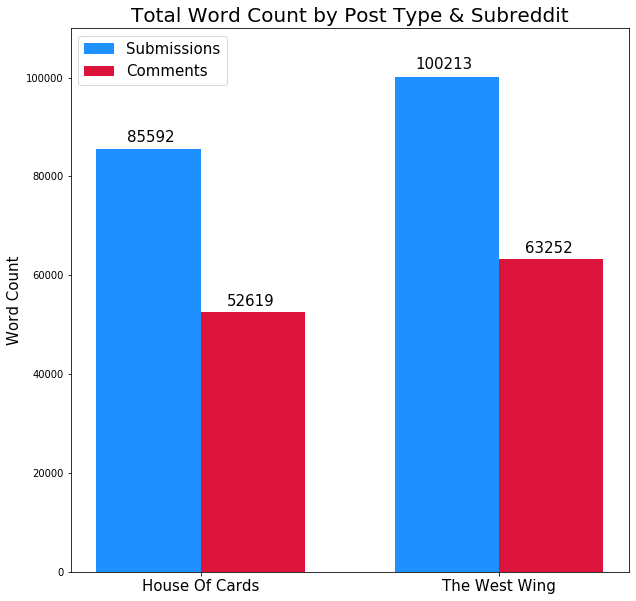

In [9]:
# Assigns the total word count by subreddit to a variable for each 
# post type (submission and comment)
sub_words = list(west_house[west_house['submission'] == 1].groupby('subreddit')['word_count'].sum())
com_words = list(west_house[west_house['submission'] == 0].groupby('subreddit')['word_count'].sum())

# The following code was adapted from https://matplotlib.org/gallery/api/barchart.html
ind = np.arange(2)
width = 0.35
fig, ax = plt.subplots(figsize=(10, 10))
sub = ax.bar(ind - width/2, sub_words, width, color='dodgerblue', label='Submissions')
com = ax.bar(ind + width/2, com_words, width, color='crimson', label='Comments')
plt.title('Total Word Count by Post Type & Subreddit', fontsize=20)
ax.set_ylabel('Word Count', fontsize=15)
ax.set_xticks(ind)
ax.set_xticklabels(['House Of Cards', 'The West Wing'], fontsize=15)
ax.legend(fontsize=15)
ax.set_ylim([0, 110_000])

def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': .5, 'right': 0.25, 'left': 0.75}

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom', fontsize=15)
autolabel(sub, "left")
autolabel(com, "right");

### Final Touches

That should be plenty of text to start with. Now let's clean it up! For the last bit of data cleaning and preprocessing, I recode my target variable as 1s and 0s, engineer the text data with the nltk library's word lemmatizer and stopwords list, and remove rows with no text data.

In [10]:
# Converts subreddit column as 1s and 0s, since it will be my target variable
# (I waited until now to do this so that I could iterate through the same list of subreddit names
# for both rounds of data collection and use the same variable to fill two spots in my for loop.)

west_house['subreddit'] = np.where(west_house['subreddit'] == 'thewestwing', 1, 0)

In [11]:
# Creates a function to lemmatize common word variants to their root word and
# to remove stock stopwords from nltk library
# I used the function we wrote in the NLP lesson as a template
lemmatizer = WordNetLemmatizer()
def clean_strings(post):
    post = re.sub("[^a-zA-Z]", " ", post.lower()).split()
    post = [lemmatizer.lemmatize(i) for i in post]
    right_words = [w for w in post if w not in stopwords.words('english')]
    return (" ".join(right_words))

# Applies function to text column
# I got the .apply part from a data science friend, Jake Peavy
west_house['text'] = west_house['text'].apply(clean_strings)

In [12]:
# Clear any cells with no text, which would present as NaNs when I import my data into the modelling notebook
west_house = west_house[west_house['text'] != ""]

In [13]:
# Creates column for word count and then assigns the total word count by subreddit to a variable for each 
west_house['word_count'] = [len(i.split()) for i in west_house['text']]
west_house['word_count'].sum()

163843

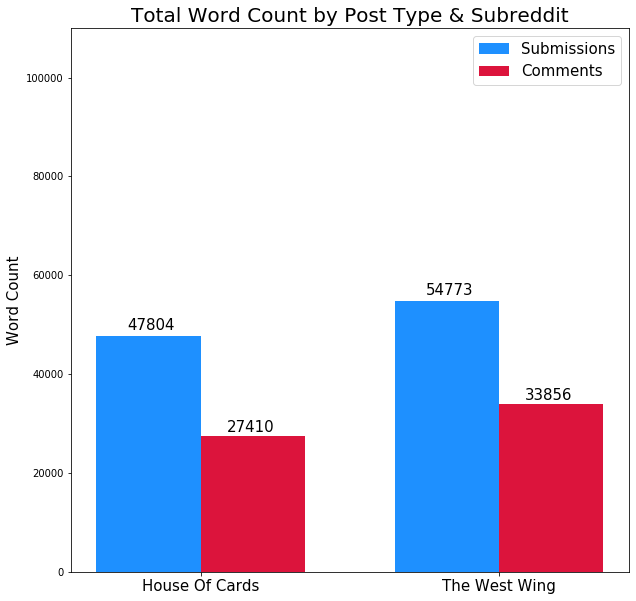

In [14]:
# Assigns the total word count by subreddit to a variable for each 
# post type (submission and comment)
sub_words = list(west_house[west_house['submission'] == 1].groupby('subreddit')['word_count'].sum())
com_words = list(west_house[west_house['submission'] == 0].groupby('subreddit')['word_count'].sum())

# The following code was adapted from https://matplotlib.org/gallery/api/barchart.html
ind = np.arange(2)
width = 0.35
fig, ax = plt.subplots(figsize=(10, 10))
sub = ax.bar(ind - width/2, sub_words, width, color='dodgerblue', label='Submissions')
com = ax.bar(ind + width/2, com_words, width, color='crimson', label='Comments')
plt.title('Total Word Count by Post Type & Subreddit', fontsize=20)
ax.set_ylabel('Word Count', fontsize=15)
ax.set_xticks(ind)
ax.set_xticklabels(['House Of Cards', 'The West Wing'], fontsize=15)
ax.legend(fontsize=15)
ax.set_ylim([0, 110_000])

def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': .5, 'right': 0.25, 'left': 0.75}

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom', fontsize=15)
autolabel(sub, "left")
autolabel(com, "right");

### Ready For Modelling

Now that my data is squeaky clean, I am read to model. I saved my dataframe as a CSV file to use in the modelling notebook.

In [15]:
west_house.to_csv('../data/west_house.csv', index=False) 